In [2]:
import pandas as pd
import numpy as np
import json
import gdown
import re

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('seaborn')
plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels

from collections import Counter

In [9]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy2
from nltk.stem import WordNetLemmatizer 

from tqdm import tqdm

[nltk_data] Downloading package stopwords to /home/sergey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sergey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sergey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
# !gdown 'https://drive.google.com/uc?id=1sqD2c_YyIdnuS7jgHyW_a9c_DC8KhXoV'

Downloading...
From: https://drive.google.com/uc?id=1sqD2c_YyIdnuS7jgHyW_a9c_DC8KhXoV
To: /home/sergey/Documents/Neyro_sets/AIIJC/EduRu/aiijc_comand_data.json
132MB [00:11, 11.9MB/s] 


## Upload data

In [4]:
with open('aiijc_comand_data.json', 'r') as f :
  data = json.load(f)
  allTexts = data['texts']
  allLinks = data['links']

In [183]:
data = pd.read_csv('marked_test.csv')
del data['Unnamed: 0']
data.head()

,task,ans
0,Вопрос 1 Денис готовится провести соревнования...,спорт
1,Реши задачу.\nСколько коробок корма для собак ...,животные
2,"Если групп элементов несколько, то применяется...",спорт
3,Вопрос1 ...,животные
4,Для наглядной геометрической иллюстрации объём...,спорт


In [167]:
unknown_data = pd.read_csv('unknown_dataset.csv')
unknown_data = unknown_data.sort_values(by = 'score')
del unknown_data['Unnamed: 0']
unknown_data = unknown_data[:200]
unknown_data.head()

,task,ans,score
711,"13.9. На сколько дней хватит 30 кг картофеля, ...",спорт,0.338962
184,\t11.31*. Для разлива по банкам приготовили 48...,спорт,0.351726
27,\t1.63. У Серёжи было 13 тетрадей в клетку и с...,спорт,0.359541
164,\t10.5. Художник устроил выставку своих работ....,литература,0.363807
441,14. Мама надоила молока и разлила его в 6 ...,музыка,0.366723


In [168]:
del unknown_data['score']
unknown_data['ans'] = 'неизвестно'

In [169]:
print(unknown_data.shape, data.shape)
data = pd.concat([data, unknown_data])
print(data.shape)

(200, 2) (514, 2)
(714, 2)


In [170]:
data.head()

,task,ans
0,Вопрос 1 Денис готовится провести соревнования...,спорт
1,Реши задачу.\nСколько коробок корма для собак ...,животные
2,"Если групп элементов несколько, то применяется...",спорт
3,Вопрос1 ...,животные
4,Для наглядной геометрической иллюстрации объём...,спорт


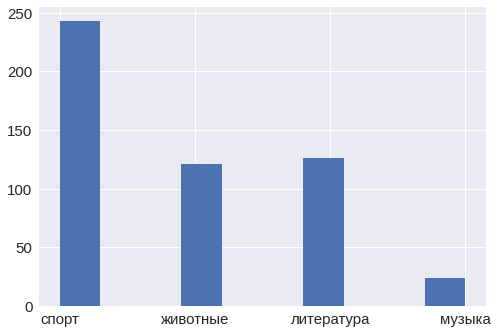

In [184]:
plt.hist(data['ans'])
plt.show()

## Prepare data

In [185]:
def data_prepare(language_dict, ru=False, en=False, es=False):

    if ru:
        stop_words = set(stopwords.words('russian'))
        lemmatizer = pymorphy2.MorphAnalyzer()
    elif en:
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
    elif es:
        stop_words = set(stopwords.words('spanish'))
        lemmatizer = nltk.stem.SnowballStemmer('spanish')
        
    dict_prepared = []
    
    for  text in tqdm(language_dict):
        text = re.sub(r'[()]', '#', text)
        text = re.sub(r'#[0-9]+#','', text)
        text = re.sub(r'[^\w\s.]','', text.lower())
        
        word_tokens = word_tokenize(text)
        word_tokens = [w for w in word_tokens if not w in stop_words]
        if ru:
            word_tokens = [lemmatizer.parse(w)[0].normal_form for w in word_tokens]
        elif en:
            word_tokens = [lemmatizer.lemmatize(w) for w in word_tokens]
        elif es:
            word_tokens = [lemmatizer.stem(w) for w in word_tokens]
        
        word_tokens = [w for w in word_tokens if not w in stop_words]
        
        filtered_text = ' '.join(word_tokens)
        filtered_text = re.sub(r' [.]+ ', ' ', filtered_text)
        dict_prepared.append( filtered_text)
    return dict_prepared

In [186]:
data['task'] = data_prepare(data['task'].values, ru = True)

100%|█████████████████████████████████████████| 514/514 [00:06<00:00, 76.86it/s]


## Train tf-idf

In [187]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

y = data['ans'].values
X_text = data['task'].values

In [188]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_text)

In [189]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(411, 4308) (103, 4308) (411,) (103,)


In [190]:
clf = LogisticRegression(penalty='l1', C=50 , verbose = 10 , solver='liblinear')


clf.fit(X_train , y_train)

[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 6
iter   6  #CD cycles 1
iter   7  #CD cycles 17
iter   8  #CD cycles 4
iter   9  #CD cycles 1
iter  10  #CD cycles 9
iter  11  #CD cycles 1
iter  12  #CD cycles 16
iter  13  #CD cycles 3
iter  14  #CD cycles 1
iter  15  #CD cycles 11
optimization finished, #iter = 15
Objective value = 1173.275637
#nonzeros/#features = 112/4309
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 5
iter   6  #CD cycles 3
iter   7  #CD cycles 1
iter   8  #CD cycles 15
iter   9  #CD cycles 3
iter  10  #CD cycles 1
iter  11  #CD cycles 18
iter  12  #CD cycles 7
iter  13  #CD cycles 1
iter  14  #CD cycles 17
iter  15  #CD cycles 2
iter  16  #CD cycles 1
iter  17  #CD cycles 23
optimization finished, #iter = 17
Objective value = 1194.021677
#nonzeros/#features = 140/4309
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  

LogisticRegression(C=50, penalty='l1', solver='liblinear', verbose=10)

optimization finished, #iter = 15
Objective value = 1682.971243
#nonzeros/#features = 213/4309


In [191]:
predict = clf.predict(X_test)
print('accuraccy ', accuracy_score(y_test, predict))

accuraccy  0.7281553398058253


In [192]:
classes = clf.classes_
classes

array(['животные', 'литература', 'музыка', 'спорт'], dtype=object)

In [193]:
def predict_tfidf(texts) :
    X_test = vectorizer.transform(texts)
    return clf.predict_proba(X_test)

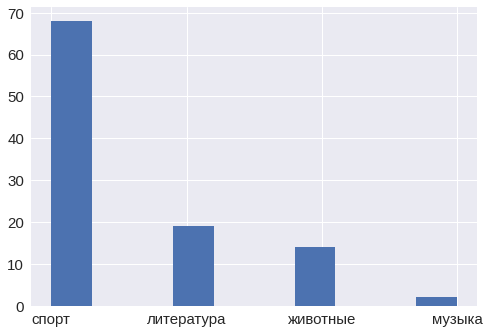

In [194]:
plt.hist(predict)
plt.show()

## Key words

In [28]:
allTexts = {}
for i in range(4) :
    allTexts[ans_text[i]] = data[data['ans'] == i]['task'].values

100%|███████████████████████████████████████| 243/243 [00:00<00:00, 1579.59it/s]


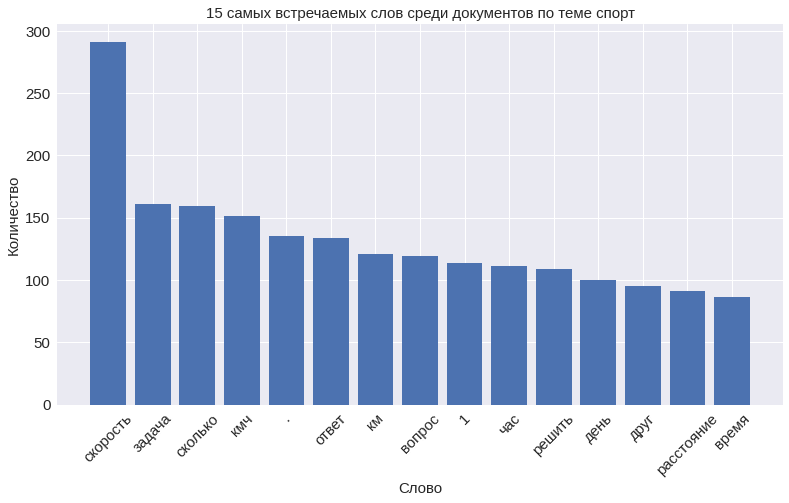

100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 1576.73it/s]


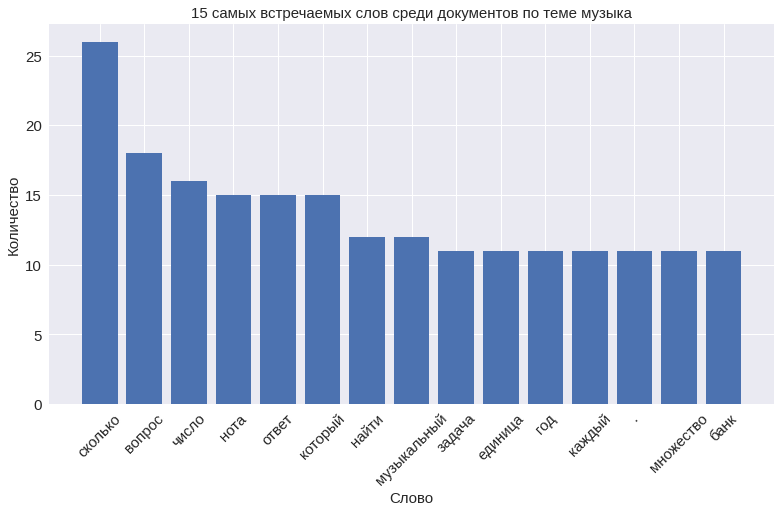

100%|███████████████████████████████████████| 126/126 [00:00<00:00, 2036.54it/s]


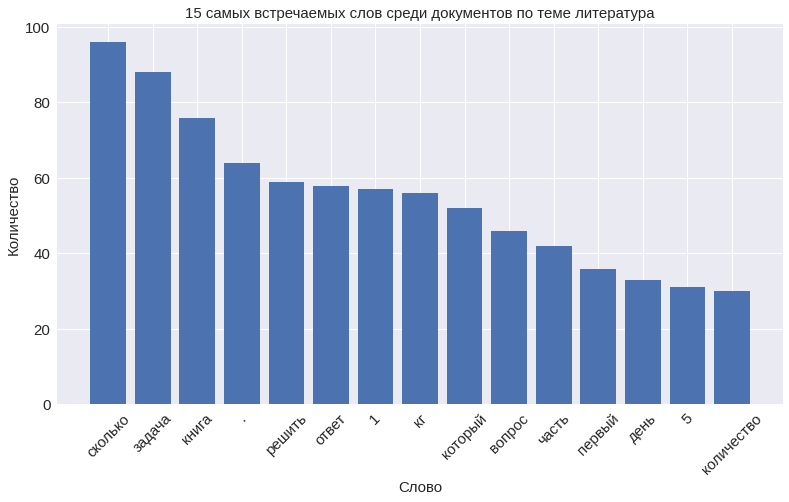

100%|███████████████████████████████████████| 121/121 [00:00<00:00, 1874.22it/s]


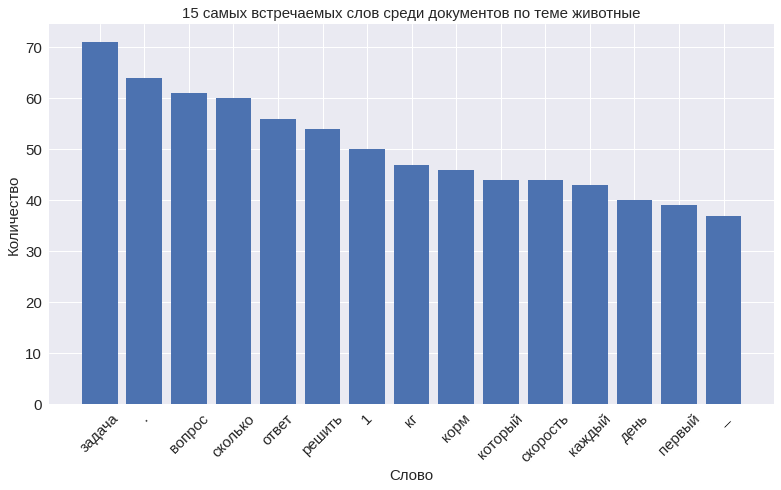

In [29]:
top_words = {}
for k in allTexts.keys() :
    ru_prepared = allTexts[k]
    words = []
    for text in tqdm(ru_prepared):
        words.extend(word_tokenize(text))
    count_words = Counter(words)
    sorted_words = sorted(count_words.items(), key=lambda count_words: count_words[1], reverse=True)
    top_words[k] = [el[0] for el in sorted_words[:15]]
    plt.figure(figsize=(13, 7))
    plt.bar(range(15), [sorted_words[i][1] for i in range(15)])
    plt.xticks(range(15), [sorted_words[i][0] for i in range(15)], rotation= 45)
    plt.title('15 самых встречаемых слов среди документов по теме {}'.format(k))
    plt.xlabel('Слово')
    plt.ylabel('Количество')
    plt.show()

In [30]:
top_words = {}
top_words['литература'] = 'книга литература стихотворение язык автор слова читать говорить'
top_words['спорт'] = 'бег соревнование спорт плавать бегать победить время страна игра человек гиря'
top_words['музыка'] = 'музыка музыкальный нота аккорд инструмент гитара скрипка петь играть'
top_words['животные'] = 'животные птица тело клетка кошка собака кормить корм выгуливать'

for k in top_words.keys() :
    top_words[k] = data_prepare(top_words[k].split(), ru=True)

100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 2826.99it/s]


In [53]:
def predict_keywords(text):
    for k, v in top_words.items():
        for word in v:
            if word in text:
                return k
    return 'UNK'

## Find good texts

In [32]:
pattern = {'zadachi1.txt' : r'[0-9]+\.[0-9]+',
           'zadachi2.txt' : r'[0-9]+\.',
           'zadachi2.5.txt' : r'[0-9]+\.',
           'zadachi3.txt' : r'[0-9]+\.[0-9]+\.',
           'zadachi5.txt' : r'№[0-9]+',
          }

In [61]:
tasks = []
for filename, pat in pattern.items() :
    texts = open('data_zadachi/{}'.format(filename), encoding = 'utf-8').read().split('\n') #cp1251
    
    for el in texts :
        if not re.search(pat, el) is None and len(el) > 50 :
            tasks.append(el)

In [62]:
len(tasks)

1927

In [63]:
prepared_tasks = data_prepare(tasks, ru=True)

100%|██████████████████████████████████████| 1927/1927 [00:07<00:00, 261.32it/s]


In [150]:
prepared_tasks[0]

'1.1. лето спортивный лагерь ходить 50 ребёнок 9 девочка сколько мальчик ходить спортивный лагерь'

In [195]:
add = []
pred = predict_tfidf(prepared_tasks)
for i in range(len(pred)):
    add.append({'task': tasks[i], 'ans': classes[np.argmax(pred[i])], 'score' : pred[i].max()})

add_df = pd.DataFrame(add)

In [196]:
good_df = add_df[add_df['score'] > 0.0]
for k in classes:
    print('{} : {}'.format(k, len(good_df[good_df['ans'] == k])))

животные : 260
литература : 357
музыка : 21
спорт : 1289


In [97]:
# add_df[add_df['score'] < 0.70].to_csv('unknown_dataset.csv')

In [199]:
good_df.to_csv('additional_dataset.csv')

In [198]:
import random
add = good_df[good_df['score'] > 0.98].to_dict('records') #T.to_dict().values()
for i in range(10) :
    print(add[random.randint(0, len(add) - 1)])

{'task': '7.63. В детской книжке 50 страниц: 16 из них без картинок, а остальные с картинками. На сколько больше страниц с картинками, чем страниц без картинок?', 'ans': 'литература', 'score': 0.9823522586180874}
{'task': '№12 Средний возраст 11 игроков футбольной команды — 22 года. Во время матча один  игрок получил травму и ушёл с поля. Средний возраст оставшихся игроков — 21 год. Сколько лет получившему травму?', 'ans': 'спорт', 'score': 0.9873011074535302}
{'task': '\t13.17. В магазине было 200 кг лимонов и апельсинов. Лимоны лежали в 5 ящиках по 20 кг, а апельсины – в нескольких ящиках по 50 кг. Сколько ящиков с апельсинами было в магазине?', 'ans': 'литература', 'score': 0.9931289415361804}
{'task': '\t14.8. Из 24 одинаковых досок можно сделать 8 скамеек. Сколько таких скамеек можно сделать из 42 досок?', 'ans': 'музыка', 'score': 0.9848309303555127}
{'task': '№6 Даны 6 чисел 1, 2, 3, 4, 5, 6. Разрешено к любым двум числам прибавить по 1. Можно ли приравнять все числа?', 'ans': '